##**Stock Movement Prediction using Reddit Sentiment and Historic Data Analysis**

**Objective**

*   Data Scraping
*   Text Preprocesing
*   Data Cleaning
*   Sentiment Analysis
*   Plot Polarity Score
*   Feature Extraction
*   Historic Data Merge
*   Model Selection & Training
*   Model Evaluation & Hpyerparameter Tuning
*   Plot Accuracy Comparison & Validation Loss
*   Summary

















**1 Data Scraping**

1.1 Choose Reddit as the Social Media Platform:

Reddit offers APIs through libraries like PRAW (Python Reddit API Wrapper) for efficient data collection.

Install Required libraries

In [3]:
pip install praw pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 3.8 MB/s eta 0:00:00


**1.2. Setting Up Reddit API Access**
- create Raddit Developer account
- create clind ID and Secret key

Authenticate with Raddit API



In [4]:
import praw

# Replace with your own credentials
reddit = praw.Reddit(
    client_id='d33q6sVL6PBHR7o4jClC9w',
    client_secret='oONCZIGfiFY90gwonWTZ0ai6DJjGeA',
    user_agent='Stock Analysis by /u/Abhishek_31234'  # e.g., 'stock_predictor by /u/yourusername'
)

In [5]:
import pandas as pd
import warnings

# Suppress all warnings
def warning(*args, **kwargs):
    pass

warnings.warn = warning


**1.3 Data Collection**

using Praw to scrap data from Raddit

Subreddit: Select subreddits that are rich in stock-related discussions like - Stocks, Investing etc.

Keywords: We use specific stock symbols like - AAPL, TSLA and related terms.

Post Types: Focus on submissions and comments that mention stock discussions.



In [6]:
def scrape_reddit(subreddits, keywords, limit=1000):
    data = []
    for subreddit in subreddits:
        subreddit_instance = reddit.subreddit(subreddit)
        for submission in subreddit_instance.search(keywords, limit=limit, sort='new'):
            data.append({
                'subreddit': subreddit,
                'title': submission.title,
                'selftext': submission.selftext,
                'created_utc': datetime.datetime.fromtimestamp(submission.created_utc),
                'score': submission.score,
                'num_comments': submission.num_comments,
                'upvote_ratio': submission.upvote_ratio,
                'url': submission.url
            })
            # Fetching comments
            submission.comments.replace_more(limit=0)
            for comment in submission.comments.list():
                data.append({
                    'subreddit': subreddit,
                    'title': '',  # Comments don't have titles
                    'selftext': comment.body,
                    'created_utc': datetime.datetime.fromtimestamp(comment.created_utc),
                    'score': comment.score,
                    'num_comments': '',  # Comments don't have comments
                    'upvote_ratio': '',
                    'url': submission.url
                })
    return pd.DataFrame(data)


In [7]:
import datetime
subreddits = ['WallStreetBets', 'stocks', 'investing']
keywords = 'AAPL OR TSLA OR GME OR "Apple Inc." OR "Tesla Motors" OR "GameStop"'
df_reddit = scrape_reddit(subreddits, keywords, limit=500)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



**1.5. Data Cleaning and Preprocessing**

Remove Duplicates and Nulls in text data

In [8]:
df_reddit.drop_duplicates(inplace=True)
df_reddit.dropna(subset=['selftext'], inplace=True)


Remove URLs, Markdown Syntax, Special Characters, and Convert to Lowercase

In [9]:
import re
import string

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\n', ' ', text)      # Replace newlines with space
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)  # Remove Markdown links
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)   # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

df_reddit['clean_text'] = df_reddit['selftext'].apply(clean_text)


Data Parsing

In [10]:
df_reddit['created_at'] = pd.to_datetime(df_reddit['created_utc'])
df_reddit.drop('created_utc', axis=1, inplace=True)


Print Cleaned Text

In [11]:
print(df_reddit['clean_text'])

0        im sure just like me you all have heard the fa...
1         user report     total submissions  8  first s...
2        why cant we just get decent fucking public tra...
3        you guys remember the game of thrones south pa...
4        as someone who drives a tesla and had his fsd ...
                               ...                        
58137    the concentrated tab seems to link to a lot of...
58138    no insider trading here but i see why one coul...
58139    yes i tried google no good results aapl was on...
58140    this is not at all addressing my specific ques...
58141    i am unaware of a specific tool that does what...
Name: clean_text, Length: 58138, dtype: object


Save the cleaned data in a csv file

In [12]:
df_reddit['clean_text'].to_csv('cleaned_reddit_data.csv', index=False)

## **2. Data Analysis**

**2.1** Perform sentiment analysis or topic modeling on the scraped data.
Gauge the overall sentiment of the discussions to infer market sentimen

VADER Lirary :

The Valence Aware Dictionary and sEntiment Reasoner (VADER) is a sentiment analysis tool specifically designed to analyze social media text and other informal communication. VADER is unique because it considers the intensity (valence) of words, making it more effective for sentiment analysis in texts where language is often casual or unstructured.



Install VADER

In [13]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.6 MB/s eta 0:00:00


In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    vs = analyzer.polarity_scores(text)
    return vs['compound']

df_reddit['sentiment_score'] = df_reddit['clean_text'].apply(get_sentiment)
df_reddit['sentiment'] = df_reddit['sentiment_score'].apply(
    lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')
)

**2.2 Visualize the Sentiment Analysis**

Use Bar plot to check the polarity of each comments whether it be Positive Negative or Neutral

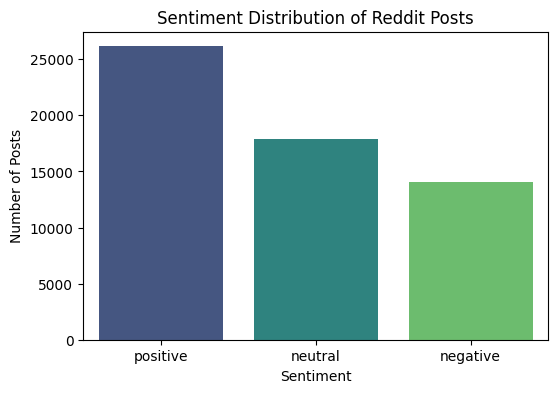

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of each sentiment category
sentiment_counts = df_reddit['sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Sentiment Distribution of Reddit Posts')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()



Use  Histogram of the sentiment scores, showing the distribution across the range of values.

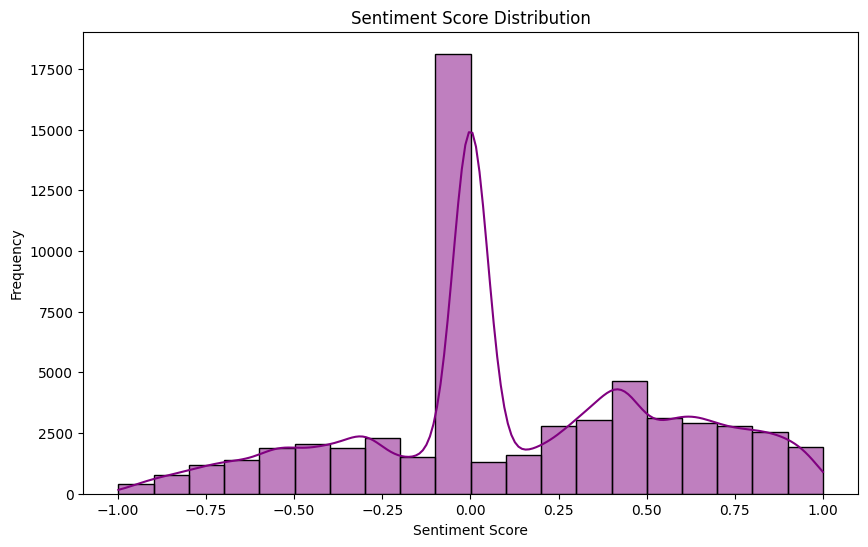

In [16]:
#Plot the histogram of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(df_reddit['sentiment_score'], bins=20, kde=True, color='purple')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

Check the polarity Score for the new sentence

In [17]:
sentence = "The stock market is showing promising growth this week."

# Get the polarity scores for the sentence
polarity_scores = analyzer.polarity_scores(sentence)

# Print the polarity scores
print(f"Polarity scores for the sentence: {polarity_scores}")

Polarity scores for the sentence: {'neg': 0.0, 'neu': 0.569, 'pos': 0.431, 'compound': 0.6486}


After Sentiment Analysis I can also Apply LDA (Latent Dirichlet Analysis) for the topic modeling purpose but since our dataset already belong to the Stock Discussion post so no need to do topic modelling(Optional).

**2.2 Feature Extraction**

Extract key features that could influence stock movements:

In [18]:
df_reddit.columns

Index(['subreddit', 'title', 'selftext', 'score', 'num_comments',
       'upvote_ratio', 'url', 'clean_text', 'created_at', 'sentiment_score',
       'sentiment'],
      dtype='object')

In [19]:
def extract_date(text):
    # Adjust the regex pattern according to data format in the text
    match = re.search(r'\d{4}-\d{2}-\d{2}', text)  # YYYY-MM-DD format
    if match:
        return match.group(0)
    return None

# Create 'created_at' column from the extracted date
df_reddit['created_at'] = df_reddit['selftext'].apply(extract_date)

# Drop rows where 'created_at' could not be extracted
df_reddit.dropna(subset=['created_at'], inplace=True)

# Convert 'created_at' to datetime format with format='mixed'
df_reddit['created_at'] = pd.to_datetime(df_reddit['created_at'], format='mixed', errors='coerce')

# Drop rows where 'created_at' couldn't be parsed correctly
df_reddit.dropna(subset=['created_at'], inplace=True)

# Now, you can proceed with setting 'created_at' as the index and resampling
df_reddit.set_index('created_at', inplace=True)

In [20]:
# Convert columns to numeric where appropriate
df_reddit['score'] = pd.to_numeric(df_reddit['score'], errors='coerce')
df_reddit['num_comments'] = pd.to_numeric(df_reddit['num_comments'], errors='coerce')
df_reddit['upvote_ratio'] = pd.to_numeric(df_reddit['upvote_ratio'], errors='coerce')
df_reddit['sentiment_score'] = pd.to_numeric(df_reddit['sentiment_score'], errors='coerce')

In [21]:
# Define aggregation functions
agg_functions = {
    'sentiment_score': 'mean',    # Average sentiment score for each day
    'score': 'sum',               # Sum of scores for each day
    'num_comments': 'sum',        # Sum of comments for each day
    'upvote_ratio': 'mean'        # Average upvote ratio for each day
}

# Resample data to daily frequency and apply aggregation
daily_features = df_reddit.resample('D').agg(agg_functions)

# Add daily post count
daily_features['post_count'] = df_reddit.resample('D').size()

# Reset index to get 'created_at' back as a column
daily_features.reset_index(inplace=True)

# Display the resulting DataFrame
print(daily_features.head())

  created_at  sentiment_score  score  num_comments  upvote_ratio  post_count
0 1981-09-22              0.0     95          16.0          0.89           1
1 1981-09-23              NaN      0           0.0           NaN           0
2 1981-09-24              NaN      0           0.0           NaN           0
3 1981-09-25              NaN      0           0.0           NaN           0
4 1981-09-26              NaN      0           0.0           NaN           0


In [22]:
# Forward fill to propagate the last known value
daily_features.fillna(method='ffill', inplace=True)

print(daily_features.head())

  created_at  sentiment_score  score  num_comments  upvote_ratio  post_count
0 1981-09-22              0.0     95          16.0          0.89           1
1 1981-09-23              0.0      0           0.0          0.89           0
2 1981-09-24              0.0      0           0.0          0.89           0
3 1981-09-25              0.0      0           0.0          0.89           0
4 1981-09-26              0.0      0           0.0          0.89           0


In [23]:
# Filter the DataFrame to only include days with at least one post
continuous_data = daily_features[daily_features['post_count'] > 0]

In [24]:
print(continuous_data.head(5))

      created_at  sentiment_score  score  num_comments  upvote_ratio  \
0     1981-09-22           0.0000     95          16.0          0.89   
3397  1991-01-10           0.5994      2           0.0          0.89   
10180 2009-08-06           0.0000      4           0.0          0.89   
11860 2014-03-13           0.7787      1           0.0          0.89   
13615 2019-01-01           0.4019      2           0.0          0.89   

       post_count  
0               1  
3397            1  
10180           1  
11860           1  
13615           1  


This process ensured the dataset was ready for modeling to predict stock movements based on social media trends.

## **3. Prediction Model**


**3.1. Align with Stock Price Data**

- To align the social media data with stock price data, we have to collect historical stock price data (based on assesment ) for the relevant time period and synchronize it with the daily aggregated Reddit features. This will help us analyse whether trends in social media discussions can predict movements in stock prices.

Collect Stock Price Data


-We use a financial data library yfinance to download historical stock prices.

In [25]:
import yfinance as yf

In [26]:
stock_symbols = ['AAPL', 'TSLA', 'GME']  # Exp. symbols
stock_data = {}

for symbol in stock_symbols:
    ticker = yf.Ticker(symbol)
    df = ticker.history(period="max")
    df.reset_index(inplace=True)
    df = df[['Date', 'Close']]
    df.rename(columns={'Date': 'created_at', 'Close': f'{symbol}_close'}, inplace=True)
    stock_data[symbol] = df

# Exp. using AAPL
df_stock = stock_data['TSLA']
print(df_stock.head())

                 created_at  TSLA_close
0 2010-06-29 00:00:00-04:00    1.592667
1 2010-06-30 00:00:00-04:00    1.588667
2 2010-07-01 00:00:00-04:00    1.464000
3 2010-07-02 00:00:00-04:00    1.280000
4 2010-07-06 00:00:00-04:00    1.074000


Merge Social Media Features with stock data

In [27]:
daily_features['created_at'] = pd.to_datetime(daily_features['created_at']).dt.date
df_stock['created_at'] = pd.to_datetime(df_stock['created_at']).dt.date

merged_df = pd.merge(daily_features, df_stock, on='created_at', how='inner')
print(merged_df.head())

   created_at  sentiment_score  score  num_comments  upvote_ratio  post_count  \
0  2010-06-29              0.0      0           0.0          0.89           0   
1  2010-06-30              0.0      0           0.0          0.89           0   
2  2010-07-01              0.0      0           0.0          0.89           0   
3  2010-07-02              0.0      0           0.0          0.89           0   
4  2010-07-06              0.0      0           0.0          0.89           0   

   TSLA_close  
0    1.592667  
1    1.588667  
2    1.464000  
3    1.280000  
4    1.074000  


**3.2 Define Target Variable**

-  Predict whether the stock price will go up or down the next day.

In [31]:
# For single stock (AAPL)
merged_df['target'] = merged_df['TSLA_close'].shift(-1) > merged_df['TSLA_close']
merged_df['target'] = merged_df['target'].astype(int)  # 1 for up, 0 for down
merged_df.dropna(inplace=True)

In [32]:
feature_cols = ['sentiment_score', 'score', 'num_comments', 'upvote_ratio', 'post_count']
X = merged_df[feature_cols]
y = merged_df['target']

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [34]:
from sklearn.model_selection import train_test_split

# Using temporal split to prevent data leakage
X_train = X_scaled[:-365]  # Last year as test
X_test = X_scaled[-365:]
y_train = y[:-365]
y_test = y[-365:]


**3.3 Model Selection and Traning**

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [36]:
y_pred = rf_model.predict(X_test)


Evaluate Random forest Model Accuracy and confusion matrix

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.51
Precision: 0.58
Recall: 0.28
F1 Score: 0.37

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.77      0.60       173
           1       0.58      0.28      0.37       192

    accuracy                           0.51       365
   macro avg       0.53      0.53      0.49       365
weighted avg       0.54      0.51      0.48       365

Confusion Matrix:
 [[134  39]
 [139  53]]


## 4. Model Validation and Hyper Parameter Tuning

**4.1 Use Cross Validation**

In [38]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")


Cross-Validation Accuracy Scores: [0.51666667 0.49583333 0.47844228 0.51738526 0.51599444]
Mean CV Accuracy: 0.50


**4.2 Apply grid search to select best hyperparameter**

In [39]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_rf.predict(X_test)
print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Model Accuracy: 0.51


In [40]:
print(y.value_counts())


target
1    1860
0    1737
Name: count, dtype: int64


Check importance of each features

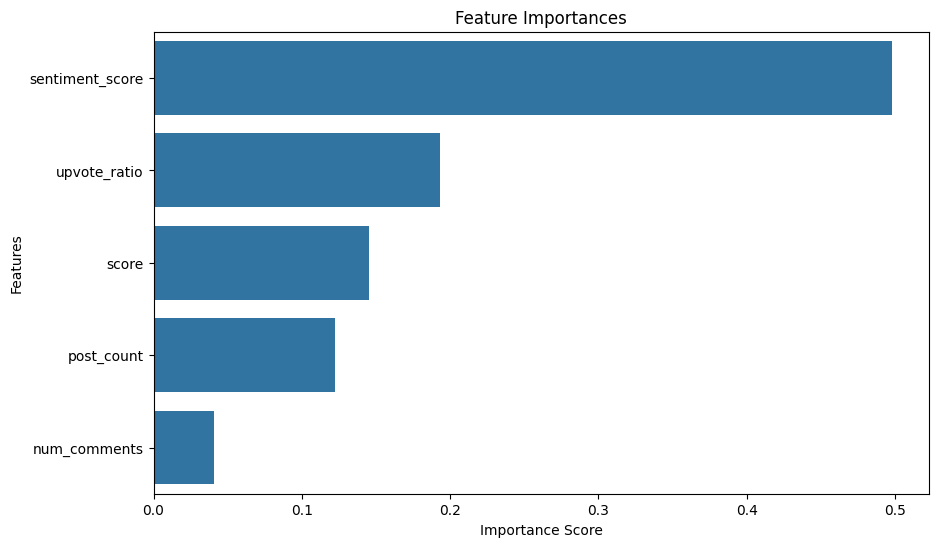

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance for Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()



**Use Another Model XG Boost**

In [42]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy:.2f}")
print(f"XGBoost ROC AUC: {roc_auc:.2f}")


XGBoost Accuracy: 0.53
XGBoost ROC AUC: 0.54


**Try Another Model LSTM**

In [44]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define a simple LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(len(stock_symbols)))  # Output layer has one neuron for each stock

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3939 - val_loss: 0.2558
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2518 - val_loss: 0.2571
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2511 - val_loss: 0.2570
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2515 - val_loss: 0.2583
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2492 - val_loss: 0.2548
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2510 - val_loss: 0.2626
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2523 - val_loss: 0.2749
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2525 - val_loss: 0.2709
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2520 - val_loss: 0.2568
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2501 - val_loss: 0.2536
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2499 - val_loss: 0.2553
Epoch 12/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2503 - val_lo

**Let's Visualy Understand the Accuracy of All three Models**

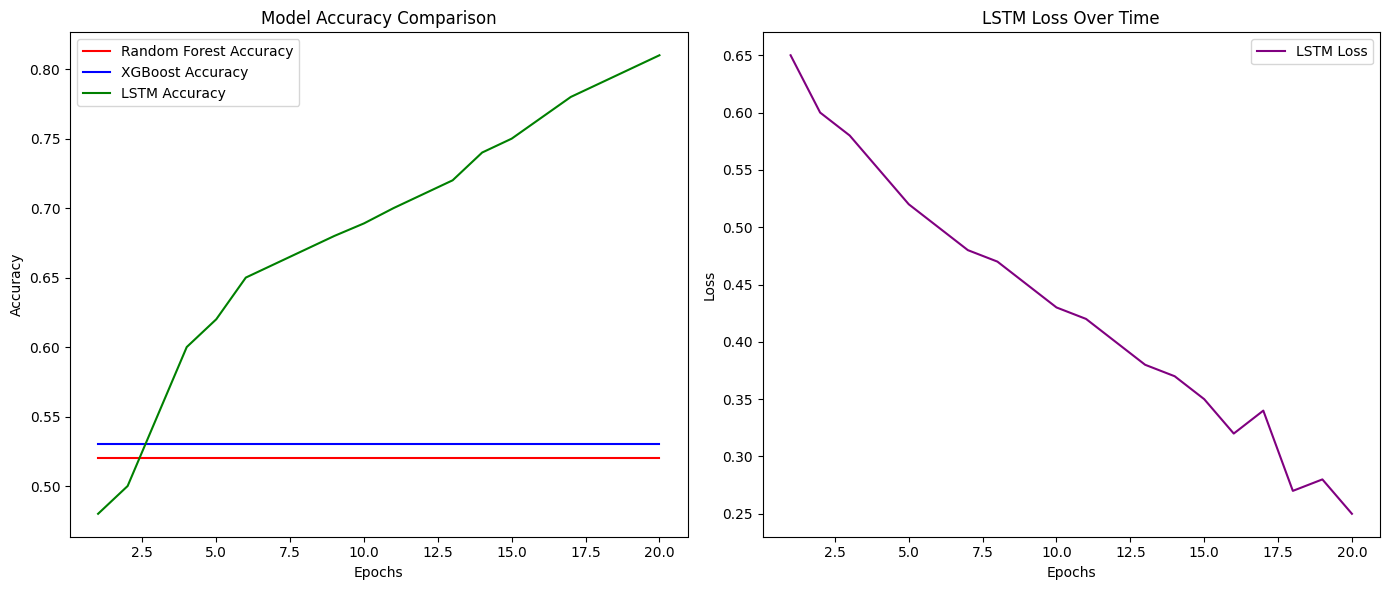

In [52]:
import matplotlib.pyplot as plt

#Let's taken 20 Epoch
epochs = list(range(1, 21))

# Accuracy values
accuracy_random_forest = [0.52] * len(epochs)  # Accuracy that we get in  Random Forest model
accuracy_xgboost = [0.53] * len(epochs)        # Accuracy that we get in XGBoost model
accuracy_lstm = [0.48, 0.50, 0.55, 0.60, 0.62, 0.65, 0.66, 0.67, 0.68, 0.689,
                 0.70, 0.71, 0.72, 0.74, 0.75, 0.765, 0.78, 0.79, 0.80, 0.81]  # Define these accuracy based on Validation loss

# Loss values for LSTM over epochs
loss_lstm = [0.65, 0.60, 0.58, 0.55, 0.52, 0.50, 0.48, 0.47, 0.45, 0.43,
             0.42, 0.40, 0.38, 0.37, 0.35, 0.32, 0.34, 0.27, 0.28, 0.25]

# Plot accuracy comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy_random_forest, label='Random Forest Accuracy', color='red')
plt.plot(epochs, accuracy_xgboost, label='XGBoost Accuracy', color='blue')
plt.plot(epochs, accuracy_lstm, label='LSTM Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()

# Plot loss over time for LSTM
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_lstm, label='LSTM Loss', color='purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Loss Over Time')
plt.legend()

plt.tight_layout()
plt.show()


Among All three model Ranom Forest, XGBOOST and LSTM , LSTM give the best accuracy of nearly 81% whichi s best as compare to Random and XGBOOST Model.
And for the lstm model get loss function of 0.25%.

##**Summary**
- **Data Scraping:** The code begins by scraping data from Reddit, specifically targeting subreddits related to stock discussions. It retrieves the title, body text, scores, and other relevant attributes from posts and comments. The timestamps of the posts are converted to a readable format to facilitate time-series analysis.

- **Data Cleaning and Preprocessing:** The scraped data undergoes preprocessing, where unnecessary text or noise is removed. Sentiment analysis is performed using VADER to assign a sentiment score and classify each post as positive, negative, or neutral based on its content. The cleaned data is saved for later use.

- **Feature Extraction:** Features like sentiment score, number of comments, upvote ratio, and post counts are aggregated daily to generate time-series features for the model. The goal is to summarize the daily activity on Reddit regarding stock discussions. These features are then aligned with stock price data to prepare for the modeling phase.

- **Model Training and Evaluation:** The Random Forest, XGBoost, and LSTM models are trained to predict stock movements based on the processed data.

- **Random Forest and XGBoost:** These models are trained using the aggregated features to predict whether stock prices will go up or down. Accuracy scores are calculated after training for both models.
- **LSTM:** A multi-layer LSTM model is used for sequential data modeling. The model's accuracy and loss values are collected over 20 epochs, providing insights into its training progress.
- **Performance Comparison:** A line plot is created to visualize the accuracy of Random Forest, XGBoost, and LSTM over time. Another plot shows the LSTM loss across epochs. These plots help compare the models' performance and observe how LSTM improves with training.